In [1]:
import os, glob
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    Resized,
    RandRotate90d,
    RandCropByPosNegLabeld,
    NormalizeIntensityd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, UNet, AttentionUnet
from monai.networks.layers import Norm

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

#from monai.data.utils import pad_list_data_collate

import torch

%matplotlib inline

print_config()

MONAI version: 0.9.dev2223
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0428f5a29f1fdc577f2c558490266d9db00583e3
MONAI __file__: /home/trojan/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
root_dir = os.path.join(os.getcwd(), "monai_data_directory")
INPUT_SIZE = (256,256,16)
print(root_dir)

/home/trojan/skia_projects/3D-CT-Artery-Segmentation/monai/monai_data_directory


# Define and load model

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=INPUT_SIZE,
    feature_size=32,  # 16
    hidden_size=768,
    mlp_dim=1024,  # 3072
    num_heads=12,
    pos_embed="perceptron",  # "conv", "perceptron"
    norm_name="instance",  # "batch", "instance"
    res_block=True,
    dropout_rate=0.0,
).to(device)

# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=3,
#     channels=(16,32,64,128,256),
#     strides=(2,2,2,2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)

In [4]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=1024, bias=True)
          (linear2): Linear(in_features=1024, out_features=768, bias=True)
          (fn): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h 

# Predict on validation data

In [5]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.4, 0.4, 0.5),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        NormalizeIntensityd(keys=["image"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=INPUT_SIZE, mode='nearest-exact'),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
data_dir = '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_16_groups'
val_images_path = os.path.join(data_dir, 'val/images')
val_labels_path = os.path.join(data_dir, 'val/labels')

val_images_list = sorted(glob.glob(val_images_path + '/*.nii.gz'))
val_labels_list = sorted(glob.glob(val_labels_path + '/*.nii.gz'))

val_files = [{'image': image_name, 'label': label_name} for image_name,label_name in zip(val_images_list, val_labels_list)]

In [7]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=1, cache_rate=1.0
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, pin_memory=True
)

Loading dataset: 100%|████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


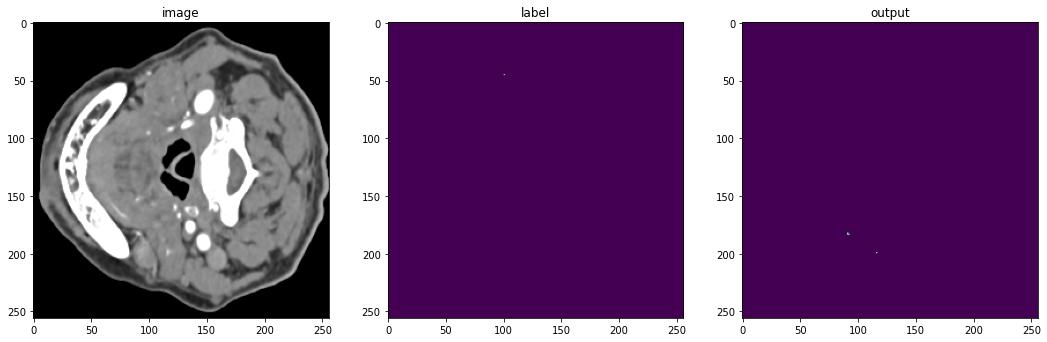

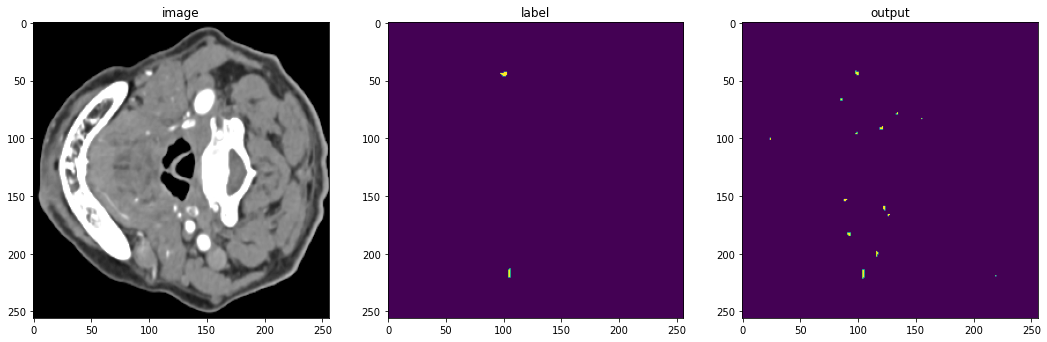

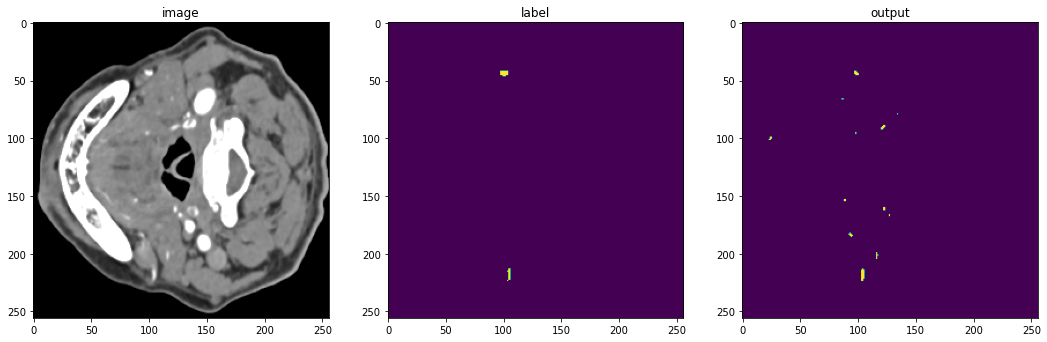

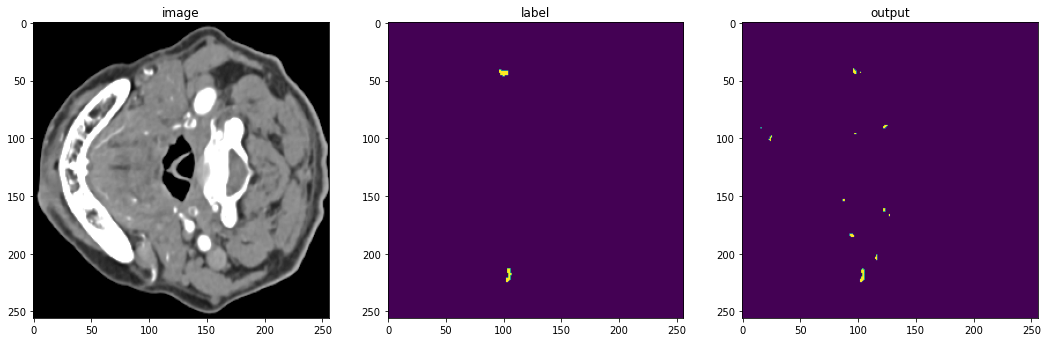

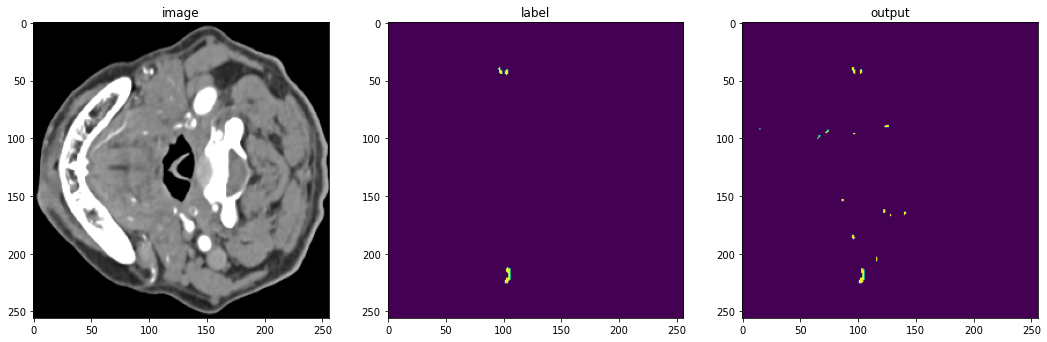

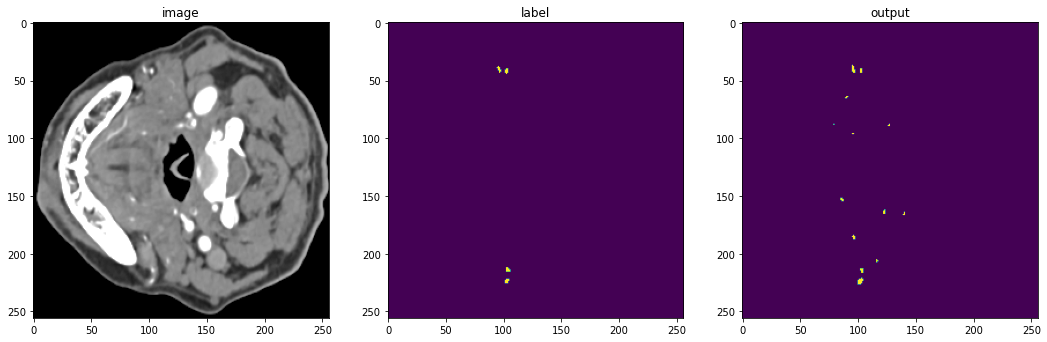

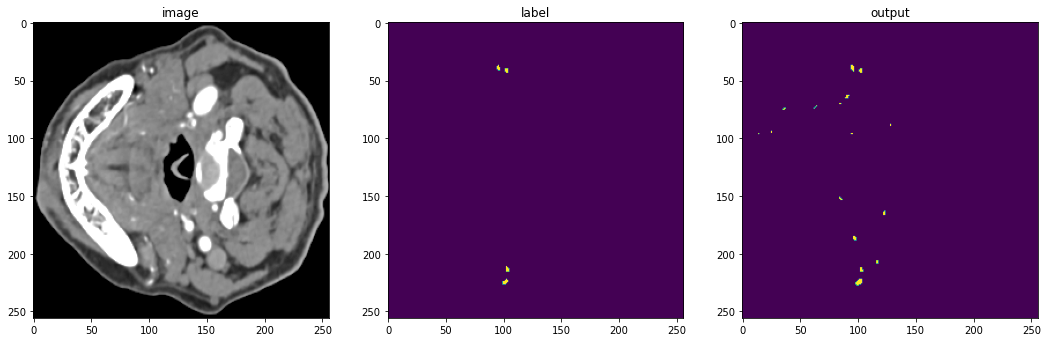

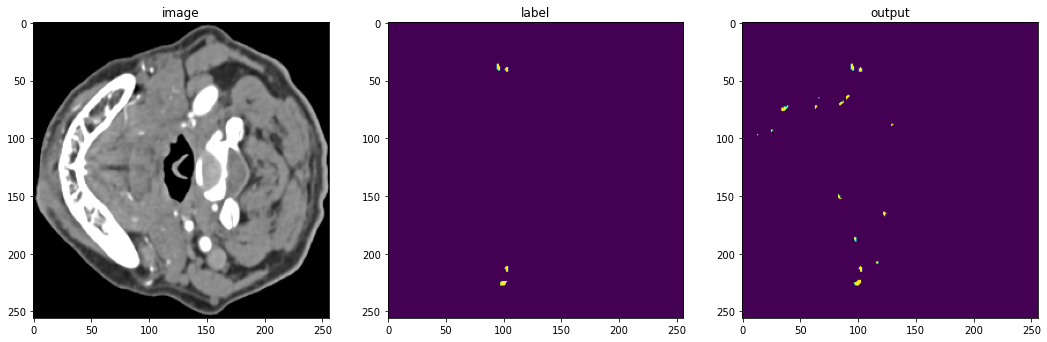

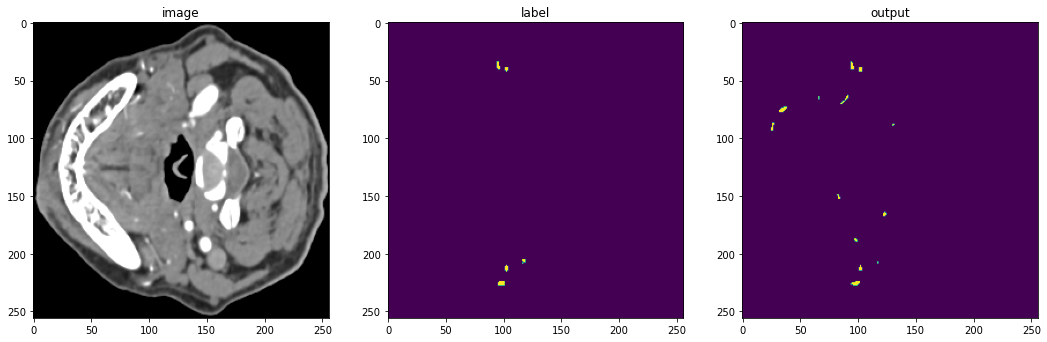

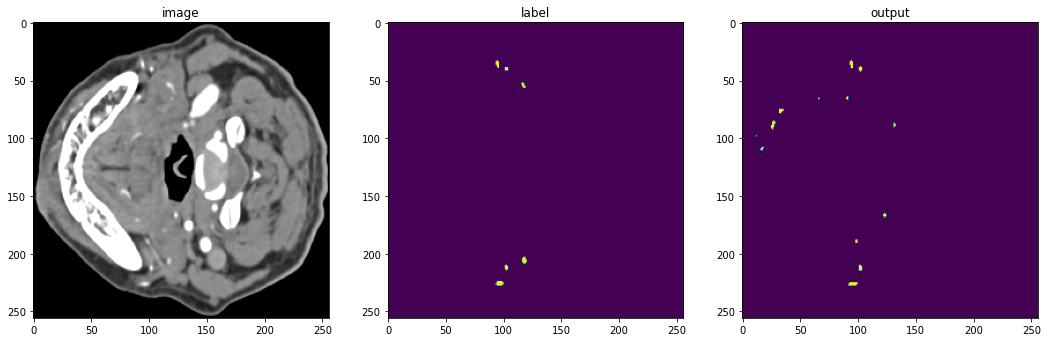

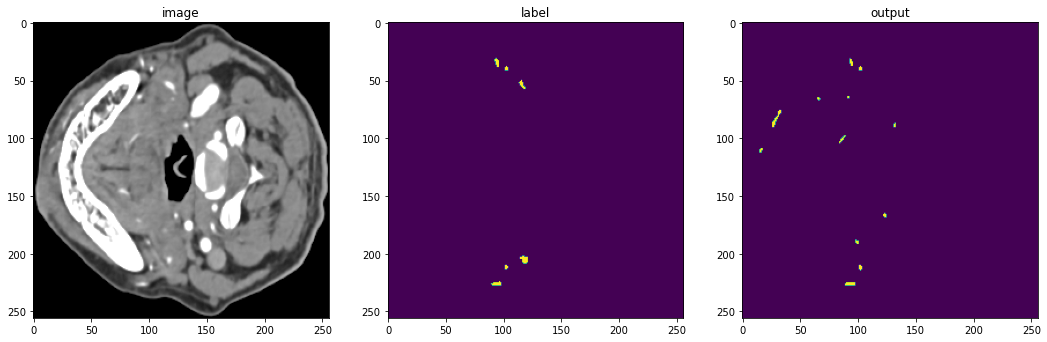

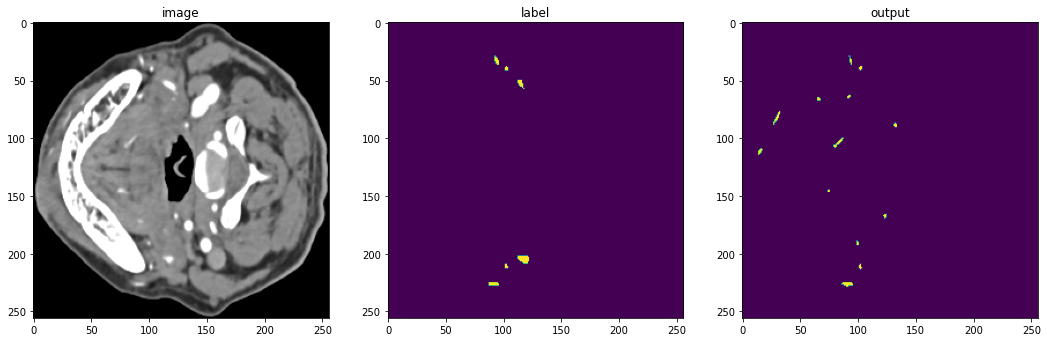

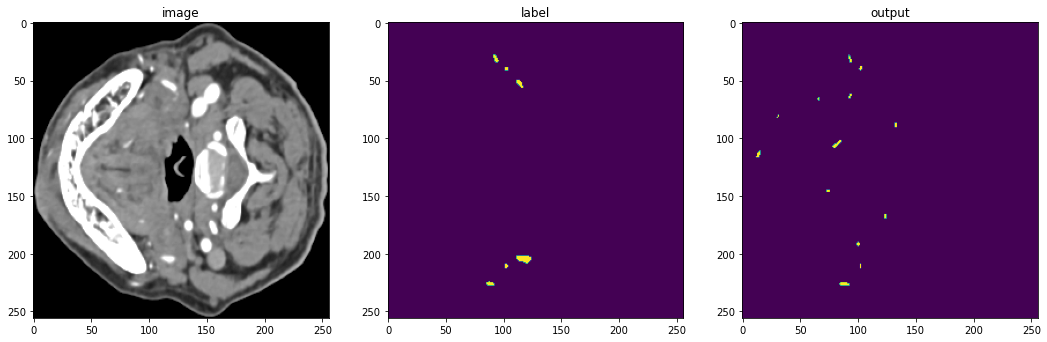

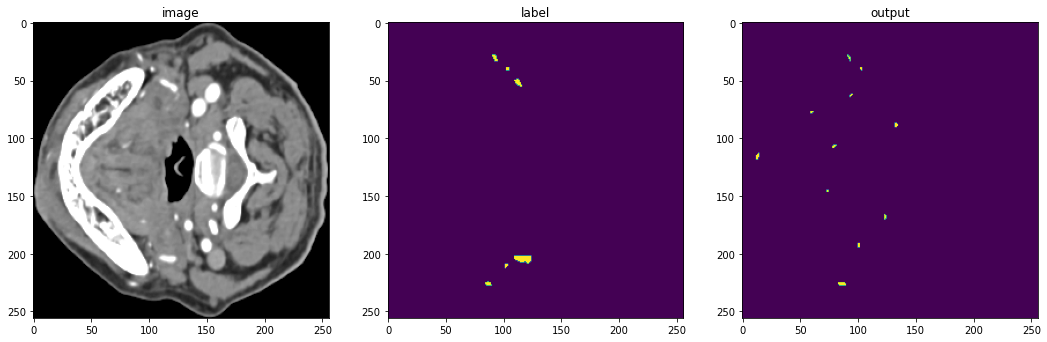

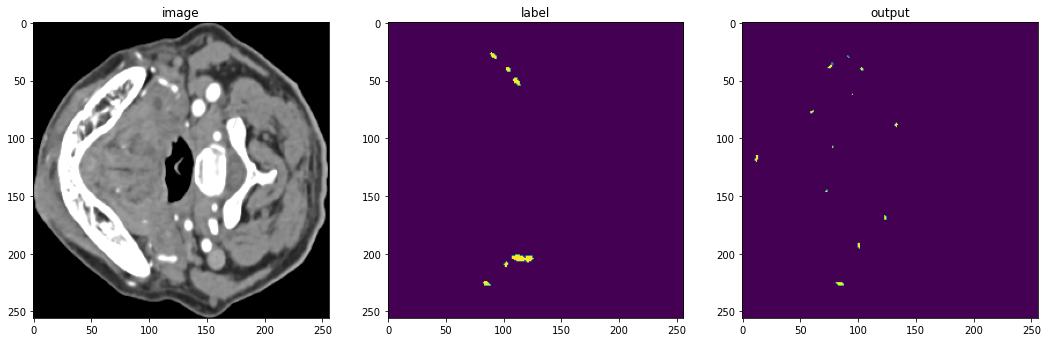

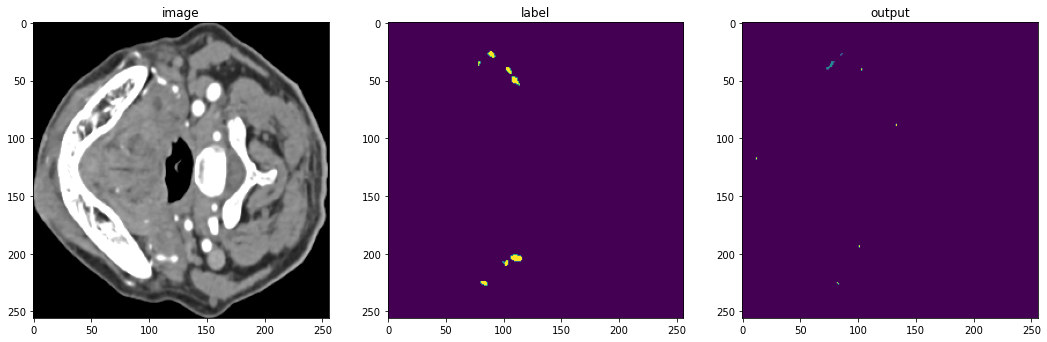

In [11]:
case_num = 1

with torch.no_grad():
    data = val_ds[case_num]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, INPUT_SIZE, 4, model
    )
#     sigmoid_activation = Activations(softmax=True)
#     val_outputs = sigmoid_activation(val_outputs)
    
    for i in range(0, 16):
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, i])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(
            torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, i]
        )
        plt.show()

In [12]:
temp_pred = torch.argmax(val_outputs, dim=1).detach().cpu()
print(np.unique(temp_pred, return_counts=True))

(array([0, 1, 2]), array([1046956,      30,    1590]))


In [13]:
temp_target = val_ds[case_num]["label"]
print(np.unique(temp_target, return_counts=True))

(array([0., 2.], dtype=float32), array([1047116,    1460]))


# Predicting on new data

## Predict on created groups

In [25]:
test_path = "/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test"

In [26]:
test_image_list = sorted(glob.glob(test_path + '/data_groups/*.nii.gz'))
test_files = [{'image': image_name} for image_name in test_image_list]

In [27]:
print(test_files)

[{'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_0.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_1.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_10.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_11.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_12.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_13.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_14.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_15.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_test/data_groups/1_16.nii.gz'}, {'image': '/media/trojan/evo/3D-CT-Artery-Segme

In [28]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(0.4, 0.4, 0.5),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        NormalizeIntensityd(keys=["image"]),
        CropForegroundd(keys=["image"], source_key="image"),
        Resized(keys=["image"], spatial_size=INPUT_SIZE, mode='nearest-exact'),
        ToTensord(keys=["image"]),
    ]
)

In [29]:
test_ds = CacheDataset(
    data=test_files, transform=test_transforms, cache_num=1, cache_rate=1.0
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, pin_memory=True
)

Loading dataset: 100%|████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


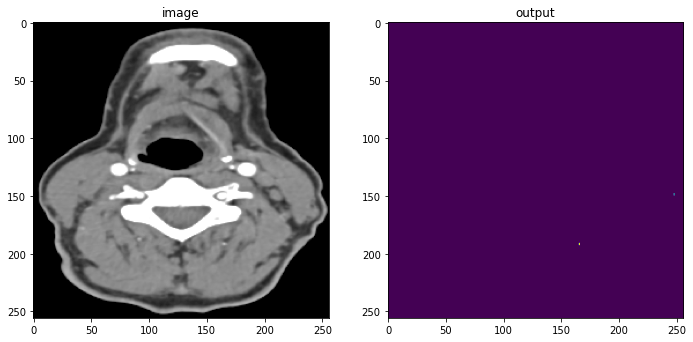

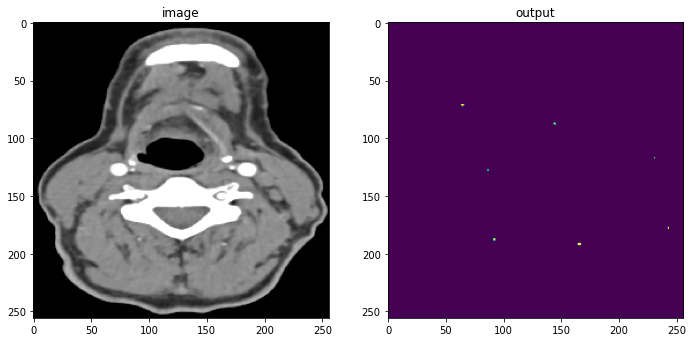

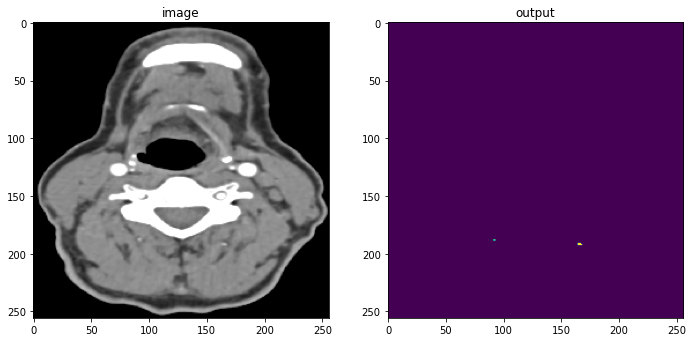

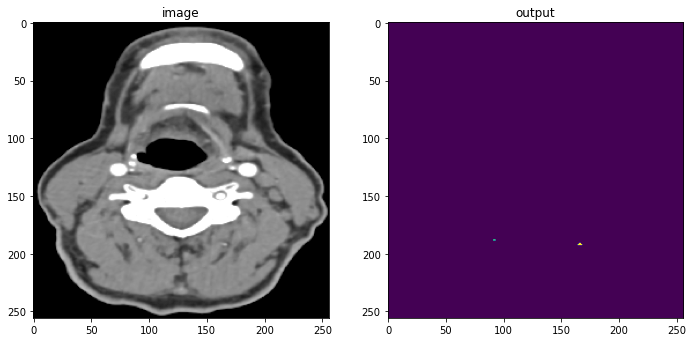

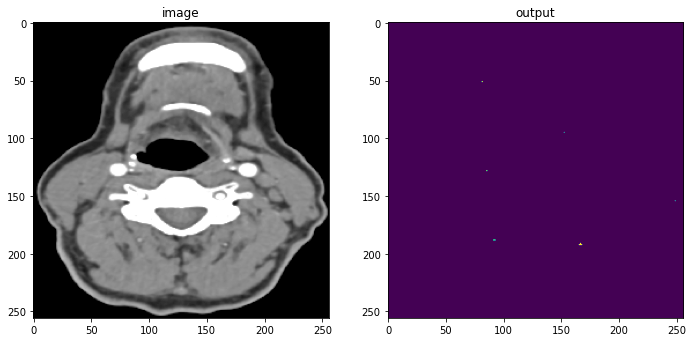

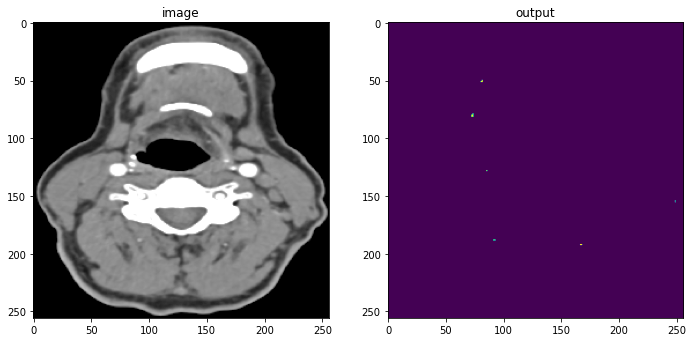

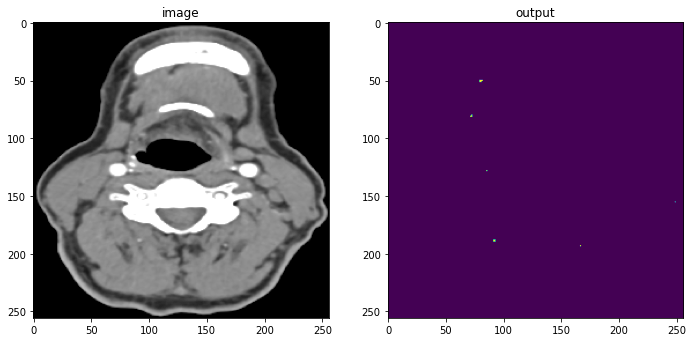

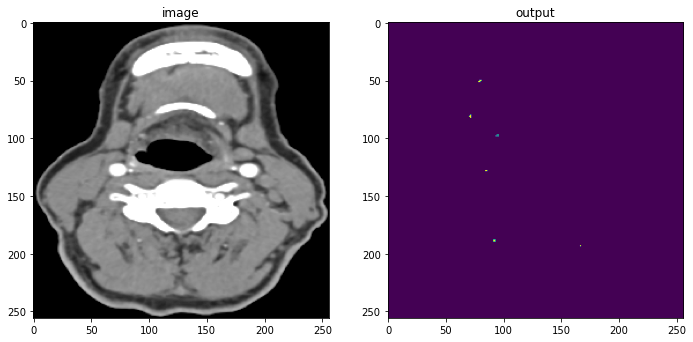

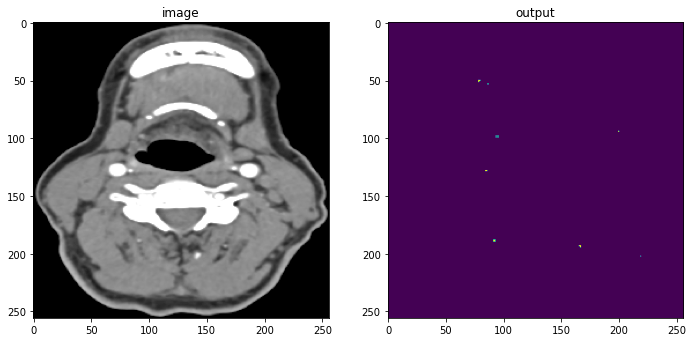

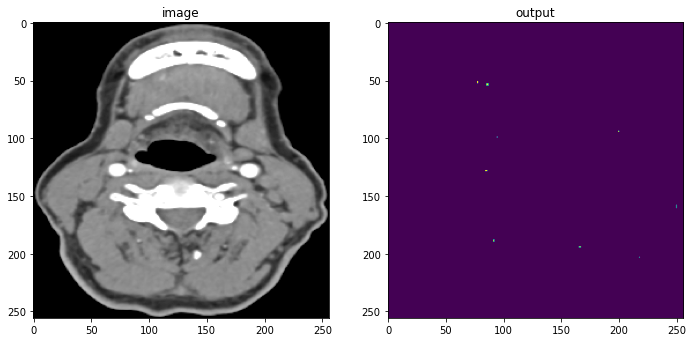

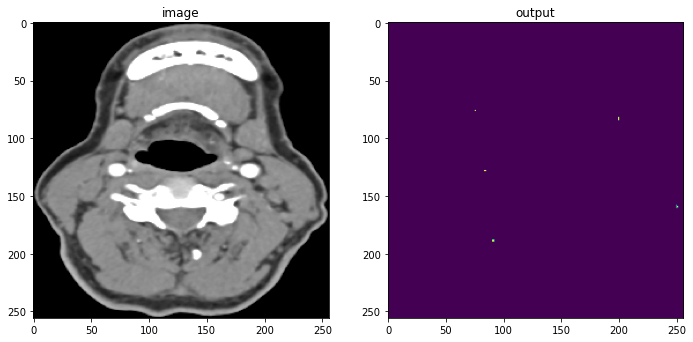

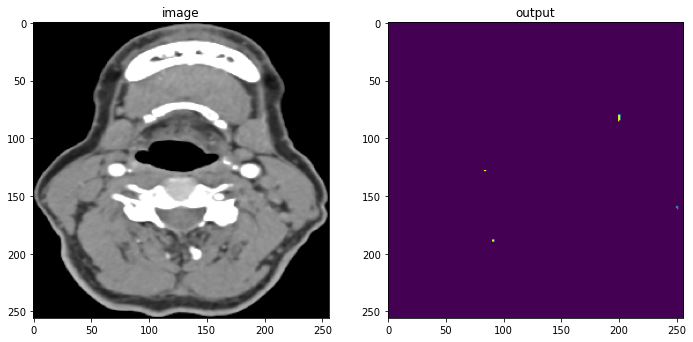

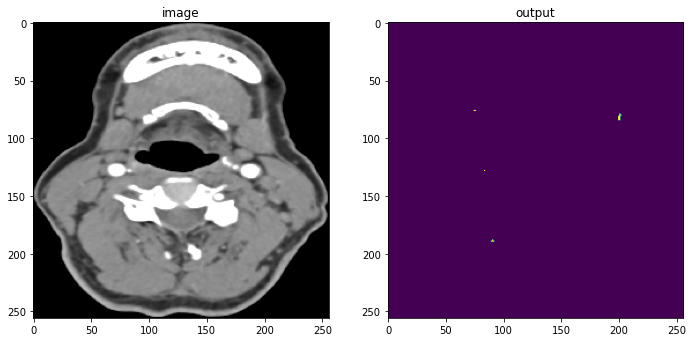

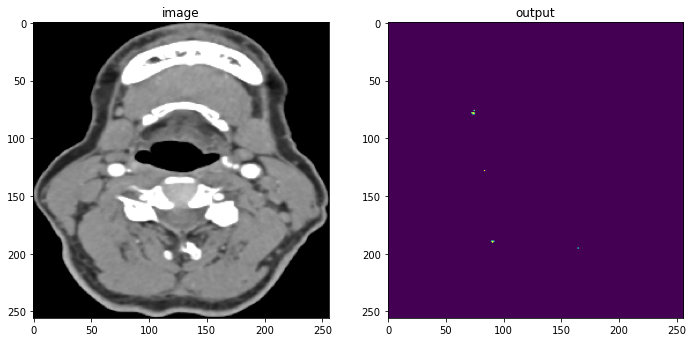

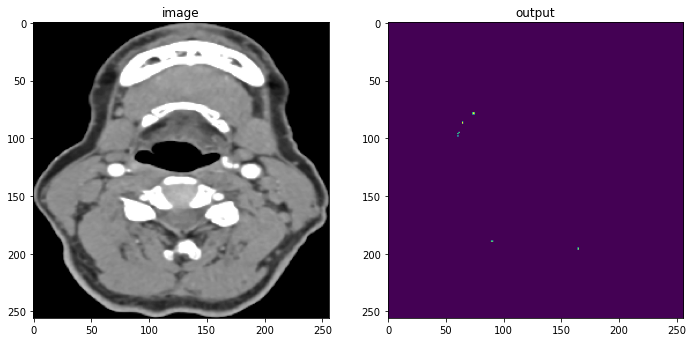

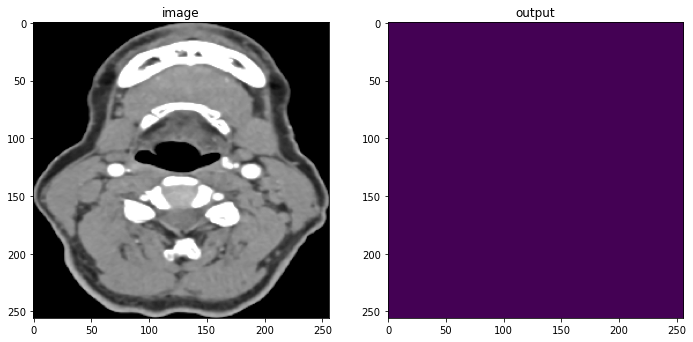

In [31]:
# Predict with fixed angle
import scipy.ndimage as ndimage

angle = 270 # in degrees

case_num = 6  # 4, 6

with torch.no_grad():
    data = test_ds[case_num]
    img = test_ds[case_num]["image"]
    test_inputs = torch.unsqueeze(img, 1).cuda()
    test_outputs = sliding_window_inference(
        test_inputs, INPUT_SIZE, 4, model, overlap=0.8
    )

    output_data = torch.argmax(test_outputs, dim=1).detach().cpu()
    
    for i in range(0, 16):
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        input_data = test_inputs.cpu().numpy()[0, 0, :, :, i]
        plt.imshow(ndimage.rotate(input_data, angle, reshape=True), cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("output")
        output_image = output_data[0, :, :, i]
        
        plt.imshow(
            ndimage.rotate(output_image, angle, reshape=True)
        )
        plt.show()

In [ ]:
# Label count in output
print(np.unique(output_data, return_counts=True))

# Save as nifti

In [18]:
data = output_data
data_array = np.array(data, dtype=np.float32)
print(data_array.shape)

(1, 512, 512, 16)


In [19]:
data_reshaped = data_array.transpose(1,2,3,0)
print(data_reshaped.shape)

(512, 512, 16, 1)


In [20]:
data_flip = np.flip(data_reshaped, axis=1)

In [21]:
import nibabel as nib
img = nib.Nifti1Image(data_flip, np.eye(4))

In [22]:
nib.save(img, os.path.abspath('./monai_data_directory/results/512x512x16/generalized_dice_loss/output.nii.gz')) 

# Save as nrrd

In [23]:
data = output_data
data_array = np.array(data, dtype=np.float32)
print(data_array.shape)

(1, 512, 512, 16)


In [24]:
data_reshaped = data_array.transpose(1,2,3,0)
print(data_reshaped.shape)

(512, 512, 16, 1)


In [25]:
data_flip = np.flip(data_reshaped, axis=0)
#data_flip = np.flip(data_reshaped, axis=1)

In [26]:
import nrrd

In [27]:
nrrd.write('./monai_data_directory/results/512x512x16/generalized_dice_loss/output.nrrd', data_flip)

# Whole volume prediction
Predict for groups of one patient and then combine them back to one volume.

In [28]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        ToTensord(keys=["image"]),
    ]
)

### Copy data to new directory patient wise
Do only once.

In [126]:
# in_dir = '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_512x512x16/data_test/data_groups'
# out_dir = '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_512x512x16/data_test/data_patients'

In [127]:
# for file in glob.glob(in_dir + '/*.nii.gz'):
#     name = file.split('/')[-1].split('.')[0].split('_')[0]
#     out_path = os.path.join(out_dir, name)
#     try:
#         os.mkdir(out_path)
#     except:
#         pass
#     !cp {file} {out_path}

In [29]:
test_path = '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_512x512x16/data_test/data_patients'
test_patients = sorted(glob.glob(test_path + '/*'))

In [31]:
image = []
#for patient in test_patients:
patient = test_patients[0]
test_image_list = sorted(glob.glob(patient + '/*.nii.gz'))
test_files = [{'image': image_name} for image_name in test_image_list]
test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=len(test_image_list), cache_rate=1.0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, pin_memory=True)

with torch.no_grad():
    for case_num in range(len(test_image_list)):
        data = test_ds[case_num]
        img = test_ds[case_num]["image"]
        test_inputs = torch.unsqueeze(img, 1).cuda()
        test_outputs = sliding_window_inference(
            test_inputs, (512, 512, 16), 4, model, overlap=0
        )

        output_data = torch.argmax(test_outputs, dim=1).detach().cpu()

        data = output_data
        data_array = np.array(data, dtype=np.float32)
        #data_reshaped = data_array.transpose(1,2,3,0)
        data_flip = np.flip(data_array, axis=1)
        image.append(data_flip)

Loading dataset: 100%|██████████████████████████| 32/32 [00:04<00:00,  7.78it/s]


In [32]:
image = np.array(image)
print(image.shape)

(32, 1, 512, 512, 16)


In [34]:
# Save groups as nrrd
import nrrd
for i in range(image.shape[0]):
    print(np.unique(image[i,0,:,:,:], return_counts=True))
    nrrd.write(f'./monai_data_directory/results/512x512x16/generalized_dice_loss/1/output_groups/{i}.nrrd', image[i,0,:,:,:])

(array([0., 1., 2.], dtype=float32), array([4193969,      24,     311]))
(array([0., 1.], dtype=float32), array([4193890,     414]))
(array([0., 1., 2.], dtype=float32), array([4194185,      69,      50]))
(array([0., 2.], dtype=float32), array([4194140,     164]))
(array([0., 2.], dtype=float32), array([4194224,      80]))
(array([0., 1., 2.], dtype=float32), array([4193863,       4,     437]))
(array([0., 2.], dtype=float32), array([4192968,    1336]))
(array([0., 1., 2.], dtype=float32), array([4191786,       5,    2513]))
(array([0., 2.], dtype=float32), array([4192601,    1703]))
(array([0., 2.], dtype=float32), array([4192685,    1619]))
(array([0., 1., 2.], dtype=float32), array([4193770,      78,     456]))
(array([0., 2.], dtype=float32), array([4193375,     929]))
(array([0., 1., 2.], dtype=float32), array([4194123,     120,      61]))
(array([0., 1., 2.], dtype=float32), array([4193220,     736,     348]))
(array([0., 1., 2.], dtype=float32), array([4193185,    1118,       1

In [35]:
temp = np.array(image)

In [36]:
# Save as one volume
arr = np.empty((512,512,0))
for i in range(0, temp.shape[0], 1):
    arr1 = np.array(temp[i,0,:,:,:])
    arr = np.concatenate((arr,arr1), axis=2)

In [37]:
print(arr.shape)
print(np.unique(arr, return_counts=True))

(512, 512, 512)
(array([0., 1., 2.]), array([134186159,     21142,     10427]))


In [38]:
arr = np.flip(arr, axis=1)

In [40]:
nrrd.write(f'./monai_data_directory/results/512x512x16/generalized_dice_loss/1/output_whole/output_whole.nrrd', arr)